### Installing dependencies

In [71]:
%pip install pandas seaborn matplotlib scikit-learn numpy openpyxl

Note: you may need to restart the kernel to use updated packages.


### Importing the necessary libraries for the workflow.

In [72]:
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.decomposition import PCA # type: ignore
from time import sleep

### Loading data

In [73]:

print("Loading data...")
data = pd.read_excel("data/01. Master_Latest data_Control clones_LP.xlsx", engine='openpyxl')
data_extracted_features = pd.read_excel("data/01. Master_Latest data_Control clones_LP.xlsx", usecols=['Batch number', 'Genotype Neuron', 'Div calculated', 'Culture treatment', 'Capacitance', 'Input Resistance', 'Resting membrane potential ', 'Maximum firing ', 'Calculated input resistance', 'Rheobase', 'EPSC freq'])
print("Data loaded\n")
sleep(1)
print(data_extracted_features.columns)

Loading data...
Data loaded

Index(['Batch number', 'Genotype Neuron', 'Div calculated',
       'Culture treatment', 'Capacitance', 'Input Resistance',
       'Resting membrane potential ', 'Maximum firing ',
       'Calculated input resistance', 'Rheobase', 'EPSC freq'],
      dtype='object')


### Preprocessing data

### Violin plot voor preprocessing

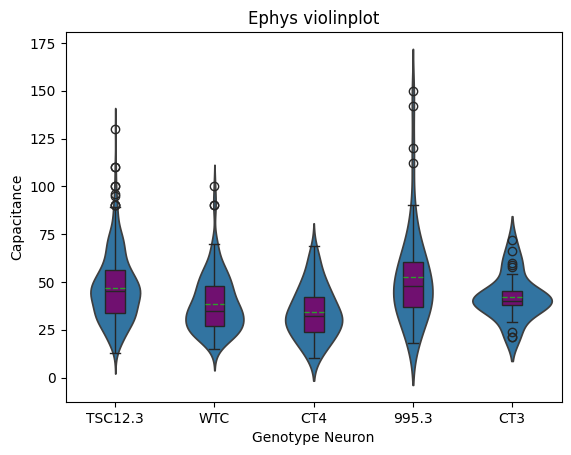

In [74]:
sns.violinplot(x='Genotype Neuron', y='Capacitance', data=data_extracted_features, inner=None)
sns.boxplot(x='Genotype Neuron', y='Capacitance', data=data_extracted_features, width=0.2, color="purple", showmeans=True, meanline=True)  
plt.xlabel("Genotype Neuron")
plt.ylabel("Capacitance")
plt.title("Ephys violinplot")
plt.show()

### Actual preprocessing

In [79]:
from sklearn.experimental import enable_iterative_imputer # type: ignore
from sklearn.impute import IterativeImputer # type: ignore

imputer = IterativeImputer(random_state=0)
#print(data_extracted_features.dtypes)
data_extracted_features_impute_copy = data_extracted_features.drop(columns=['Genotype Neuron', 'Culture treatment', 'EPSC freq'])      
data_extracted_features_imputed = imputer.fit_transform(data_extracted_features_impute_copy)
data_extracted_features_imputed = pd.DataFrame(data_extracted_features_imputed, columns=data_extracted_features_impute_copy.columns)

data_extracted_features_imputed['Genotype Neuron'] = data_extracted_features['Genotype Neuron']
data_extracted_features_imputed['Culture treatment'] = data_extracted_features['Culture treatment']
data_extracted_features_imputed['EPSC freq'] = data_extracted_features['EPSC freq']    

# for column in data_imputed.columns:
#     data_extracted_features[column] = data_imputed[column]
# data_extracted_features_imputed = data_imputed.copy()
# print(data_extracted_features_imputed.columns)

print(data_extracted_features_imputed)

Index(['Batch number', 'Div calculated', 'Capacitance', 'Input Resistance',
       'Resting membrane potential ', 'Maximum firing ',
       'Calculated input resistance', 'Rheobase', 'Genotype Neuron',
       'Culture treatment', 'EPSC freq'],
      dtype='object')
     Batch number  Div calculated  Capacitance  Input Resistance  \
0             1.0            33.0         54.0            2100.0   
1             1.0            33.0         20.0            1700.0   
2             1.0            33.0         43.0            1600.0   
3             1.0            33.0         18.0            2300.0   
4             1.0            33.0         18.0            2600.0   
..            ...             ...          ...               ...   
683           3.0            58.0         38.0            1000.0   
684           3.0            58.0         50.0            2000.0   
685           3.0            58.0         24.0            3000.0   
686           3.0            58.0         70.0        

### Violin plot na preprocessing

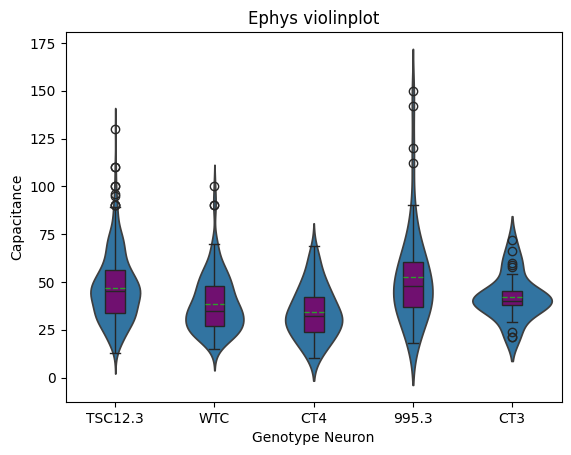

In [80]:
sns.violinplot(x='Genotype Neuron', y='Capacitance', data=data_extracted_features_imputed, inner=None)
sns.boxplot(x='Genotype Neuron', y='Capacitance', data=data_extracted_features_imputed, width=0.2, color="purple", showmeans=True, meanline=True)  
plt.xlabel("Genotype Neuron")
plt.ylabel("Capacitance")
plt.title("Ephys violinplot")
plt.show()